In [21]:
import os
import re
import boto3
from io import StringIO

import numpy as np
import pandas as pd

from pyspark import SparkContext
from pyspark.sql import SQLContext

from pyspark.sql.functions import regexp_extract
from pyspark.sql.types import *
from pyspark.sql.functions import split
from pyspark.sql import functions as F
from pyspark.sql.window import Window

import geoplot
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame

from math import sin, cos, sqrt, radians, atan2, degrees, asin

In [22]:
#sc = SparkContext("local", "First App")
sqlContext = SQLContext(sc)

#getting data from S3
s3 = boto3.resource('s3')
bucket = s3.Bucket('geo-clustering')
obj = bucket.Object(key='sample_geo_processed.csv')
response = obj.get()
lines = response[u'Body'].read().split(b'\n')
raw_data=[]
for line in lines[1:]:
     raw_data.append(str(line, 'utf-8'))
x=raw_data.pop()
print(len(lines))

9972


In [23]:
#spliiting the data to get latitudes and longitudes only
raw_rdd = sc.parallelize(raw_data)
split_rdd=raw_rdd.map(lambda line: re.split('\|',line)).map(lambda line: [line[0],line[1]])
data_df=split_rdd.toDF()

In [24]:
#finds euclidian distance
def calc_euclidian_dist(p1_lat,p1_long,p2_lat,p2_long):
    #Initializing radius of earth in KM 
    radius_of_earth=6371
    
    #Converding to radians
    p1_lat_c=radians(float(p1_lat))
    p1_long_c=radians(float(p1_long))
    p2_lat_c=radians(float(p2_lat))
    p2_long_c=radians(float(p2_long))
    
    #Finding cartesian coordinates
    x1=radius_of_earth*cos(p1_lat_c)*cos(p1_long_c)
    y1=radius_of_earth*cos(p1_lat_c)*sin(p1_long_c)
    z1=radius_of_earth*sin(p1_lat_c)
    
    x2=radius_of_earth*cos(p2_lat_c)*cos(p2_long_c)
    y2=radius_of_earth*cos(p2_lat_c)*sin(p2_long_c)
    z2=radius_of_earth*sin(p2_lat_c)
    
    euclidian_dist=sqrt((x2-x1)**2 + (y2-y1)**2 + (z2-z1)**2)
    return euclidian_dist


#finds mean of the points
def add_points(centroid):
    centroid_lat=[]
    centroid_long=[]
    for lat in centroid[0]:
        centroid_lat.append(float(lat))
    for long in centroid[1]:
        centroid_long.append(float(long))
    avg_lat_deg=sum(centroid_lat)/len(centroid_lat)
    avg_long_deg=sum(centroid_long)/len(centroid_long)
    return [avg_lat_deg,avg_long_deg] 


#finds closest centroid to each point
def closest_centroid(point):
    x=[]
    intermediate=point[0].split(" ")
    intermediate_float=[float(x) for x in intermediate]
    for i in range(0,2*k,2):
        x.append(calc_euclidian_dist(intermediate_float[i],intermediate_float[i+1],float(point[1]),float(point[2])))
    return x.index(min(x))     


#user defined pyspark functions
cc = F.udf(lambda point: closest_centroid(point), IntegerType())    
distance_old_new = F.udf(lambda point: calc_euclidian_dist(point[0],point[1],point[2],point[3]),FloatType())
add_dd = F.udf(lambda centroid: add_points(centroid), ArrayType(FloatType())) 

In [25]:
#Renaming, changing type and converting to pandas dataframe
data_df=data_df.withColumnRenamed("_1","latitude").withColumnRenamed("_2","longitude")
data_df=data_df.withColumn('latitude',data_df['latitude'].cast(DoubleType())).withColumn('longitude',data_df['longitude'].cast(DoubleType())).cache()
data_pd=data_df.toPandas()


#initializations
k=5
lat=[]
long=[]
ws=Window.orderBy(F.lit(1))
centroids=data_df.rdd.takeSample(False, k) #taking initial clusters

#collect lat and long of initial clusters
lat=[]
long=[]
for i in range(0,k):
    lat.append(centroids[i][0])
    long.append(centroids[i][1])
init_lat=pd.DataFrame(lat,columns=["latitude"])
init_long=pd.DataFrame(long,columns=["longitude"])
init = pd.concat([init_lat, init_long], axis=1)



+------------------+
|     sum(distance)|
+------------------+
|1190.8745040893555|
+------------------+

+-----------------+
|    sum(distance)|
+-----------------+
|642.6063270568848|
+-----------------+

+-----------------+
|    sum(distance)|
+-----------------+
|526.9249610900879|
+-----------------+

+------------------+
|     sum(distance)|
+------------------+
|215.18519592285156|
+------------------+

+-----------------+
|    sum(distance)|
+-----------------+
|77.00739002227783|
+-----------------+

+------------------+
|     sum(distance)|
+------------------+
|36.129082918167114|
+------------------+

+------------------+
|     sum(distance)|
+------------------+
|20.331997513771057|
+------------------+

+-----------------+
|    sum(distance)|
+-----------------+
|20.40014922618866|
+-----------------+

+------------------+
|     sum(distance)|
+------------------+
|18.261930227279663|
+------------------+

+-----------------+
|    sum(distance)|
+-----------------+
|7.700

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/geopandas/plotting.py:589: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


+------------------+
|     sum(distance)|
+------------------+
|11.012260854244232|
+------------------+

+------------------+
|     sum(distance)|
+------------------+
|10.720817804336548|
+------------------+

+-----------------+
|    sum(distance)|
+-----------------+
|5.935693994164467|
+-----------------+

+-----------------+
|    sum(distance)|
+-----------------+
|4.330499559640884|
+-----------------+



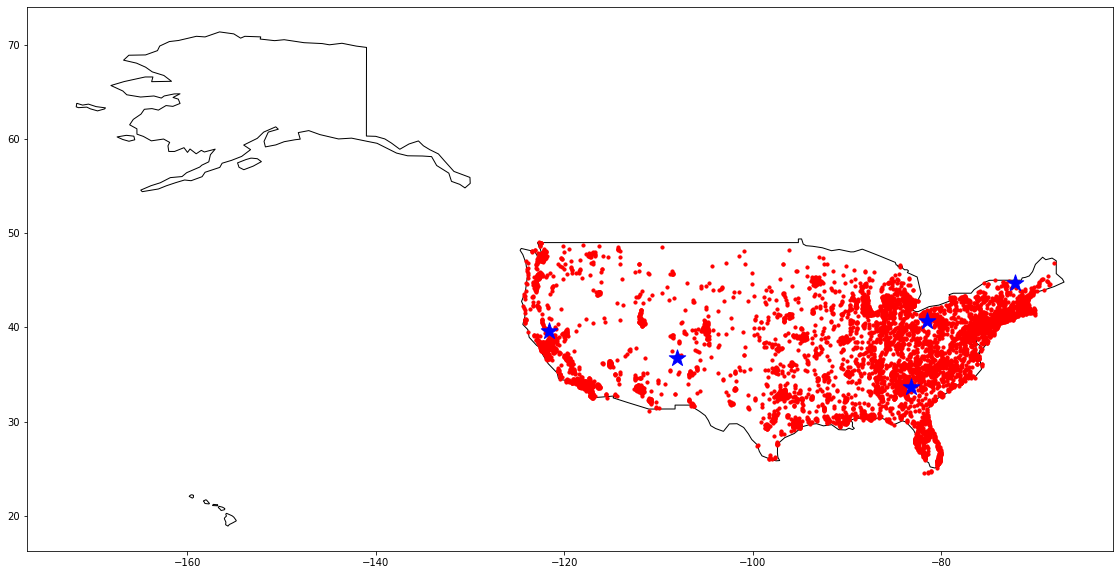

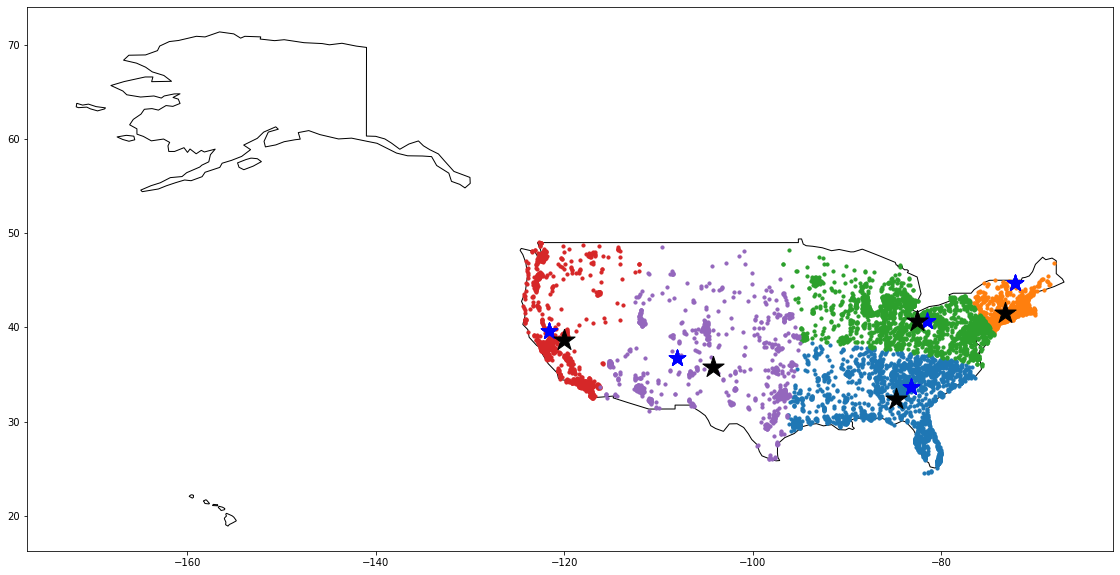

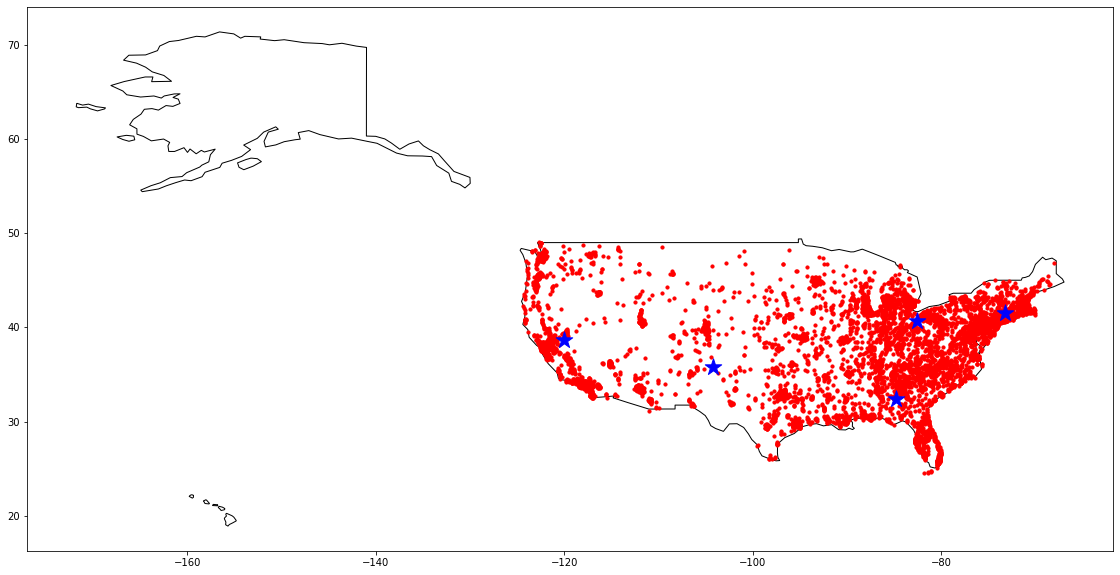

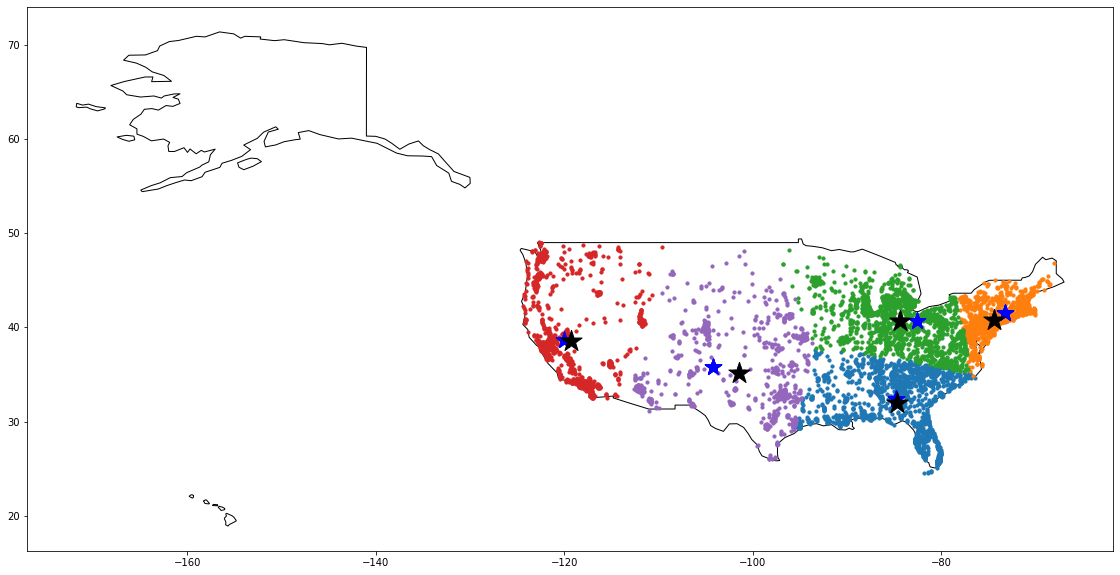

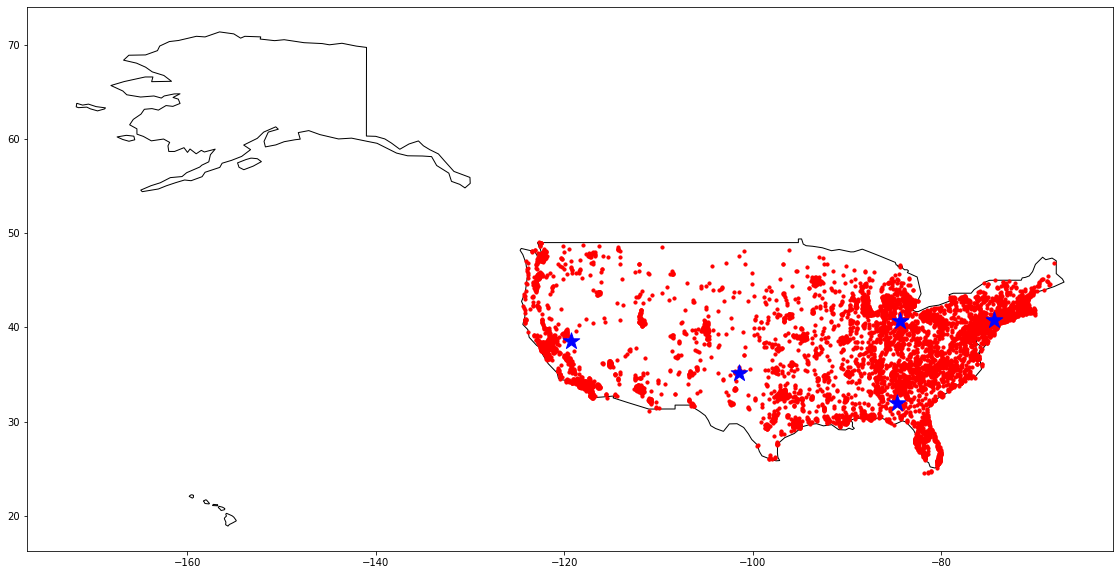

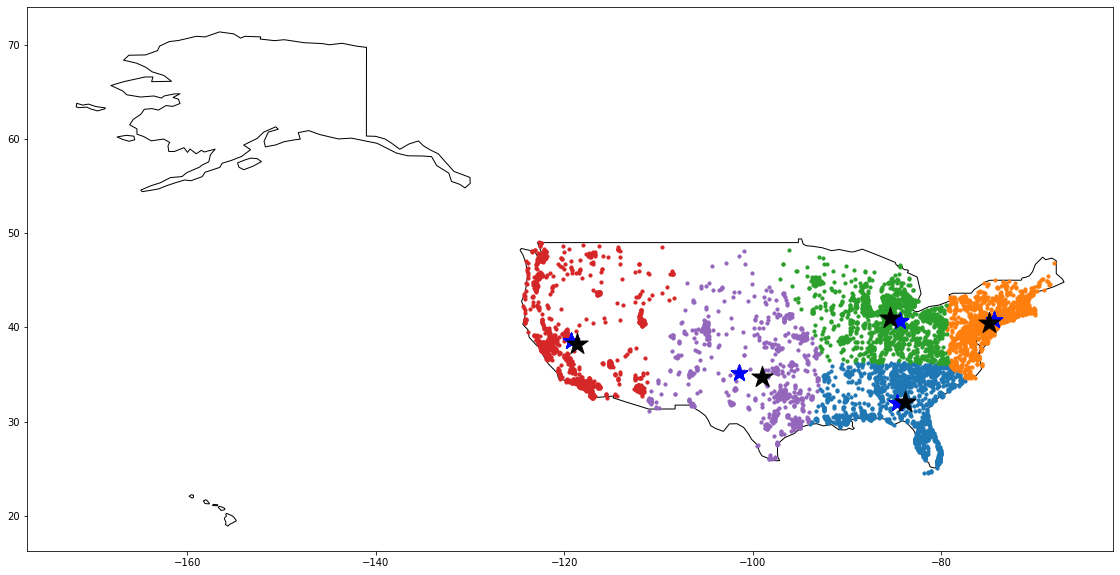

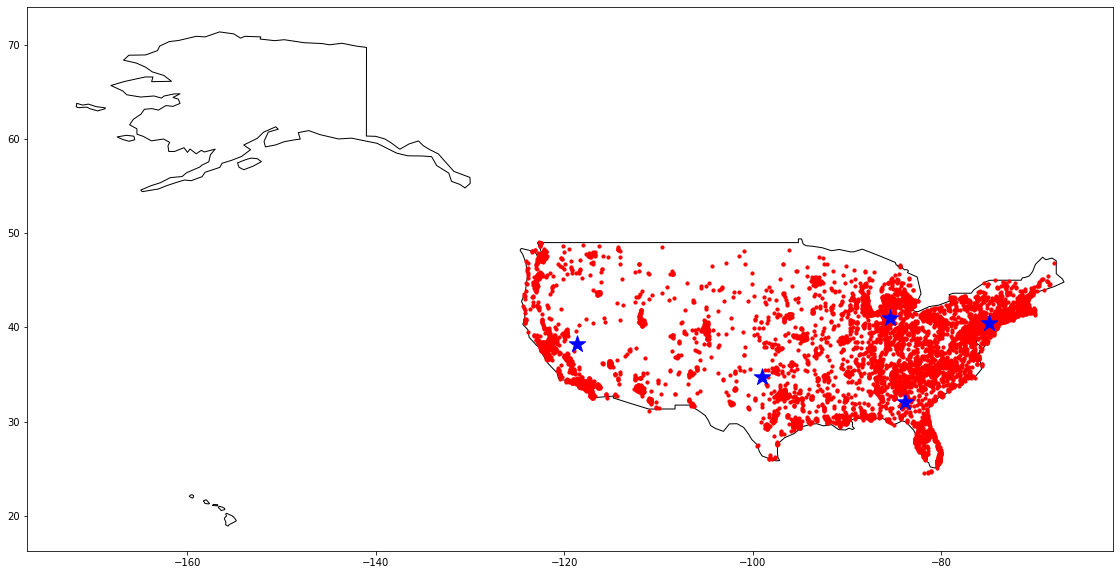

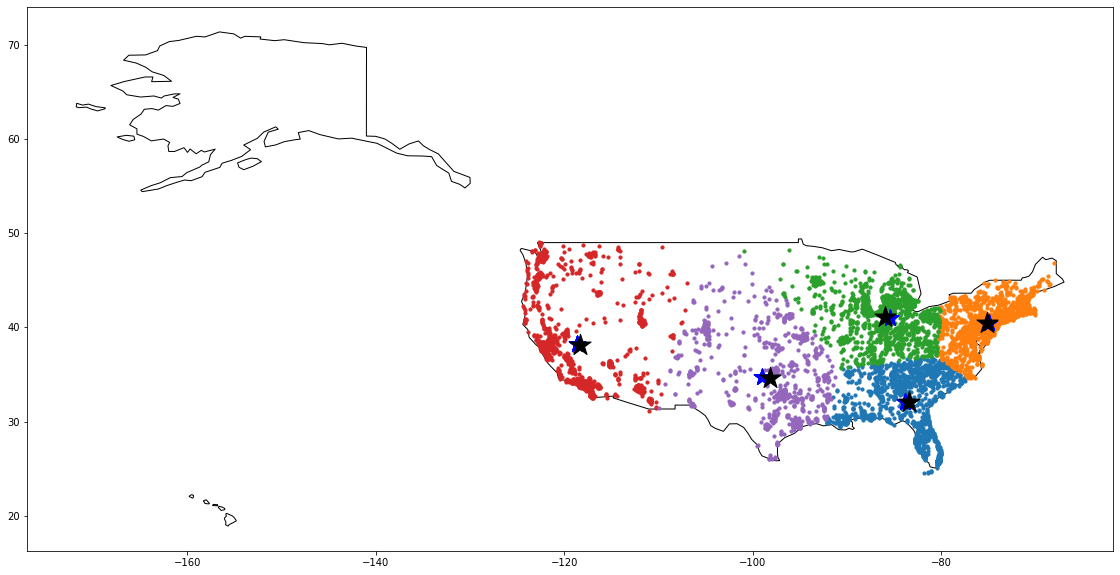

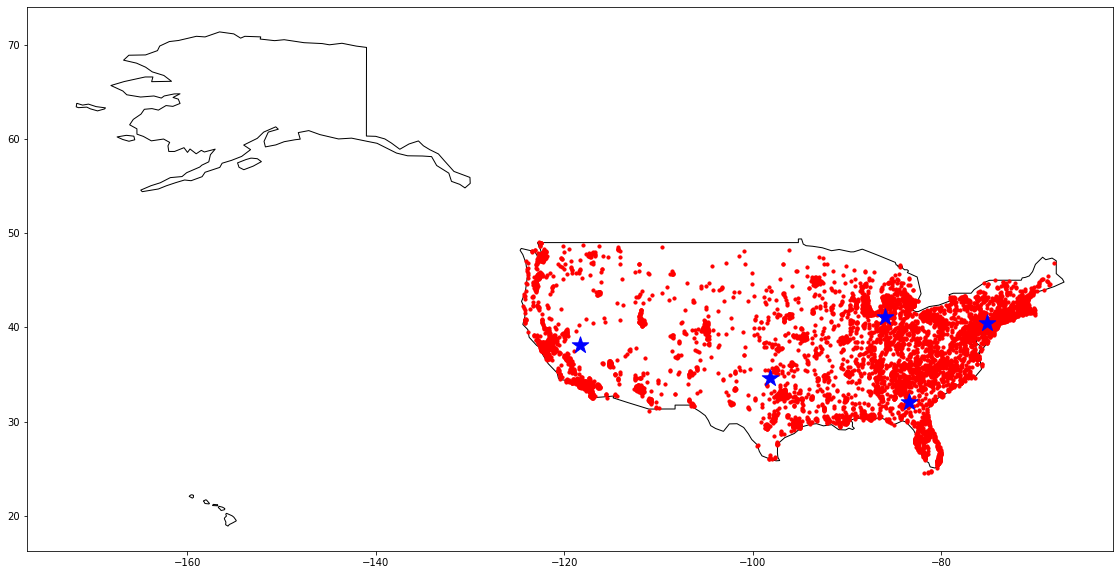

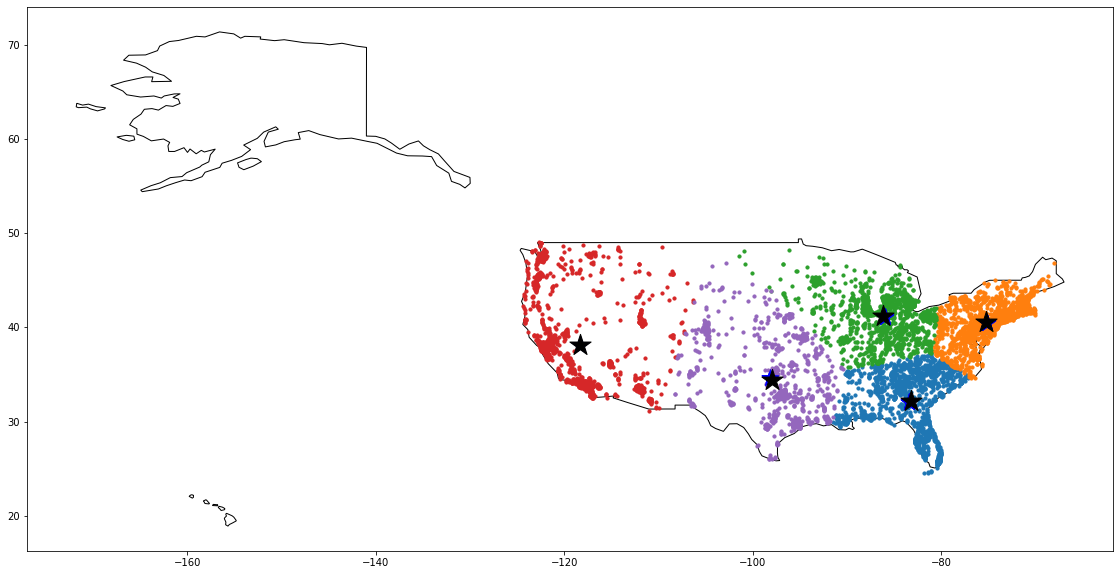

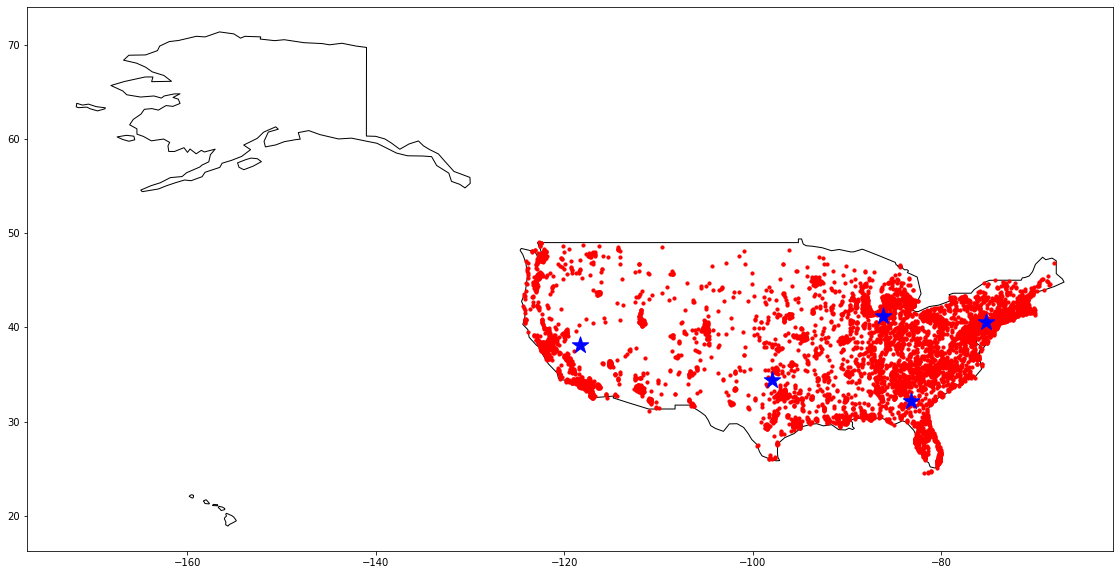

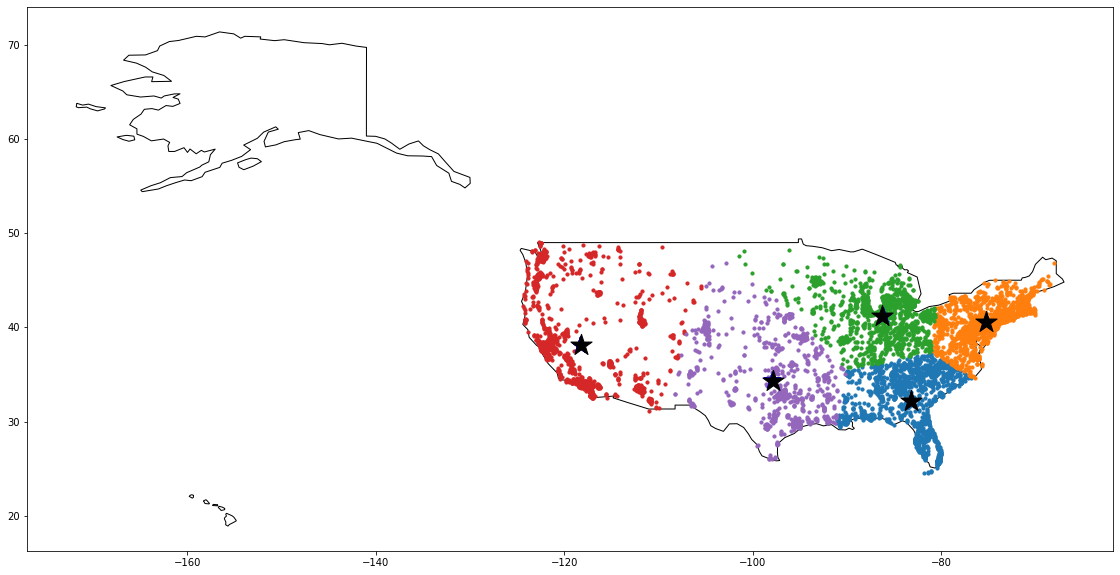

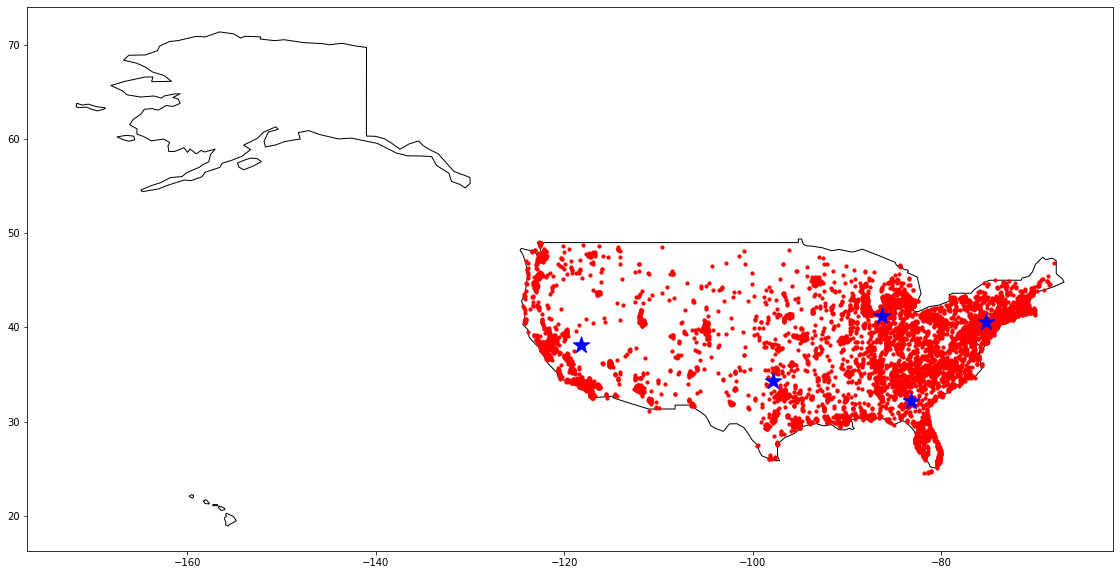

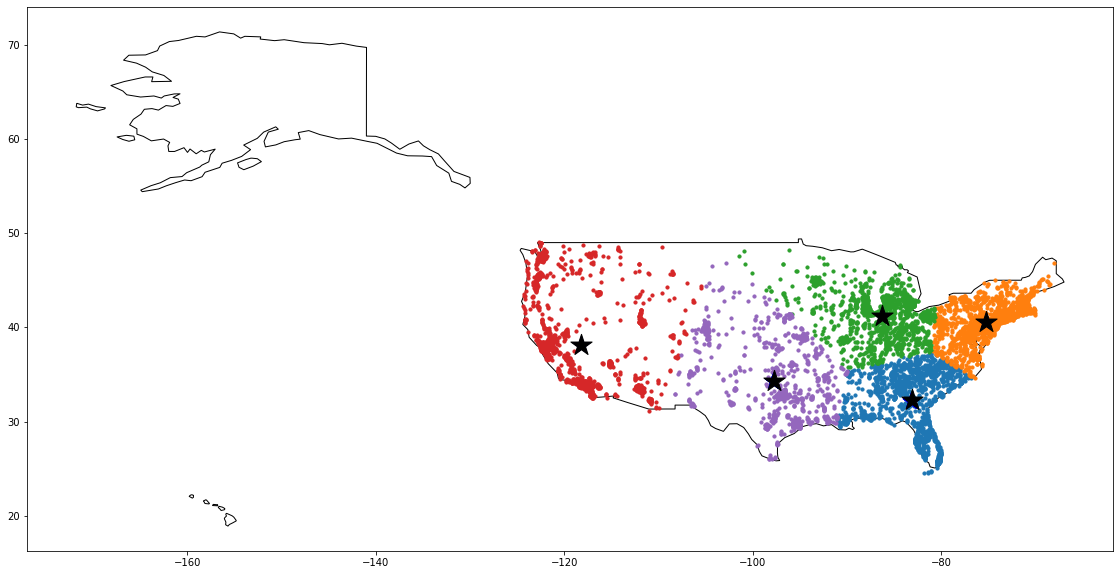

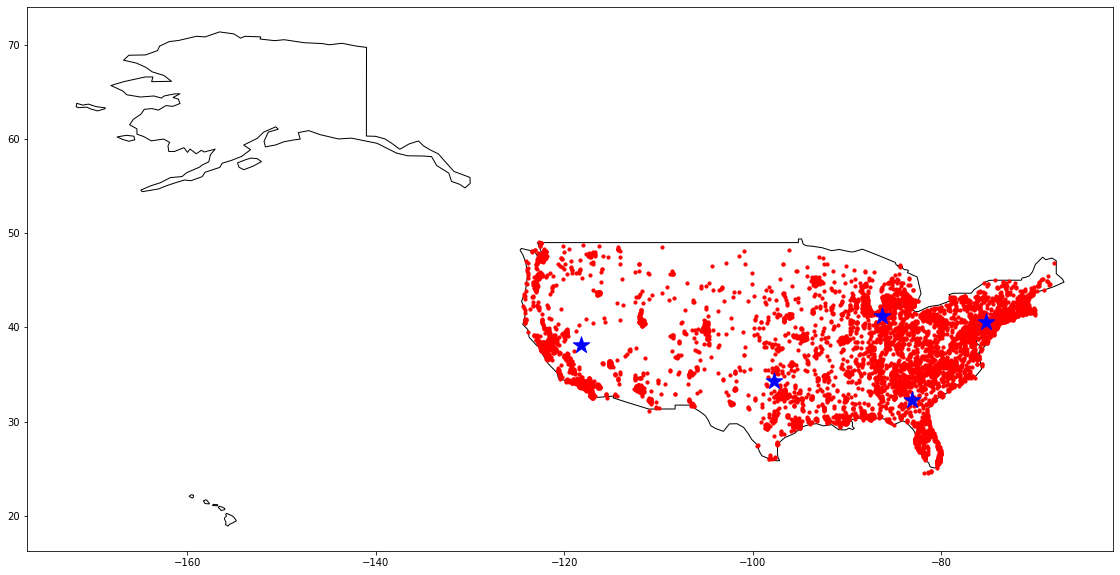

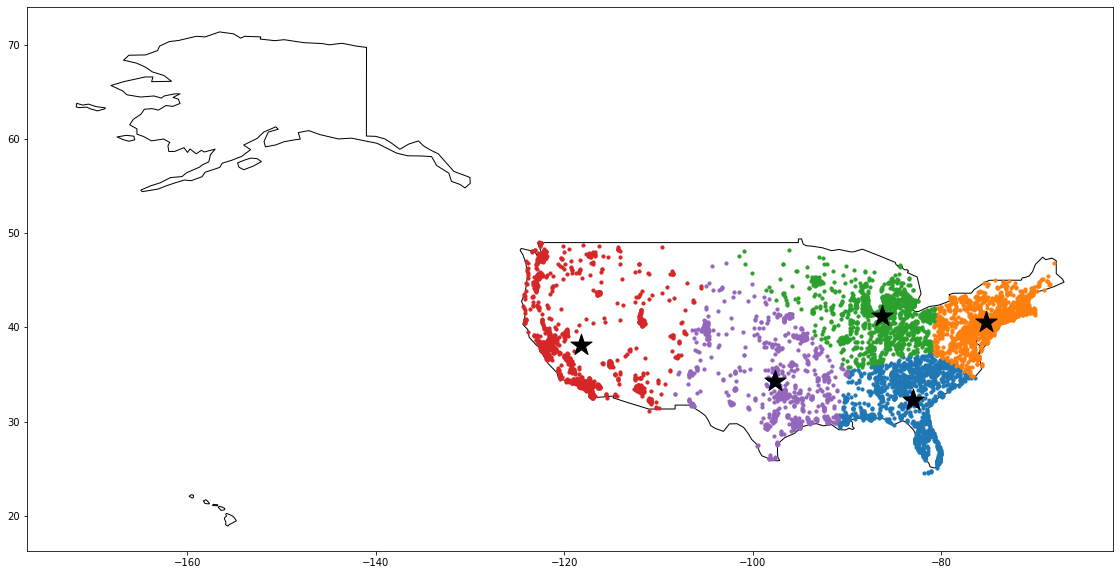

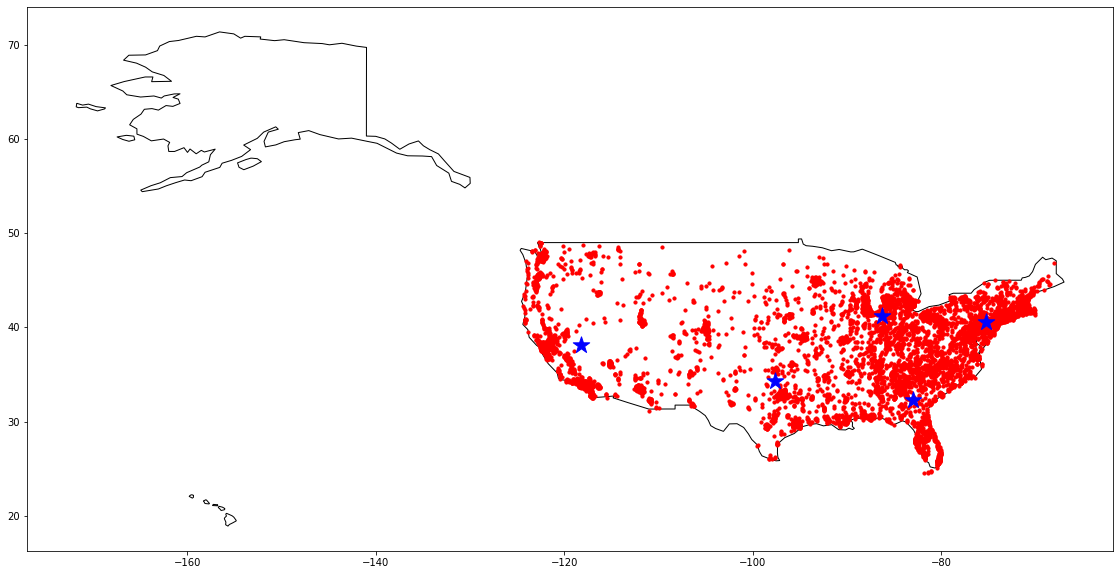

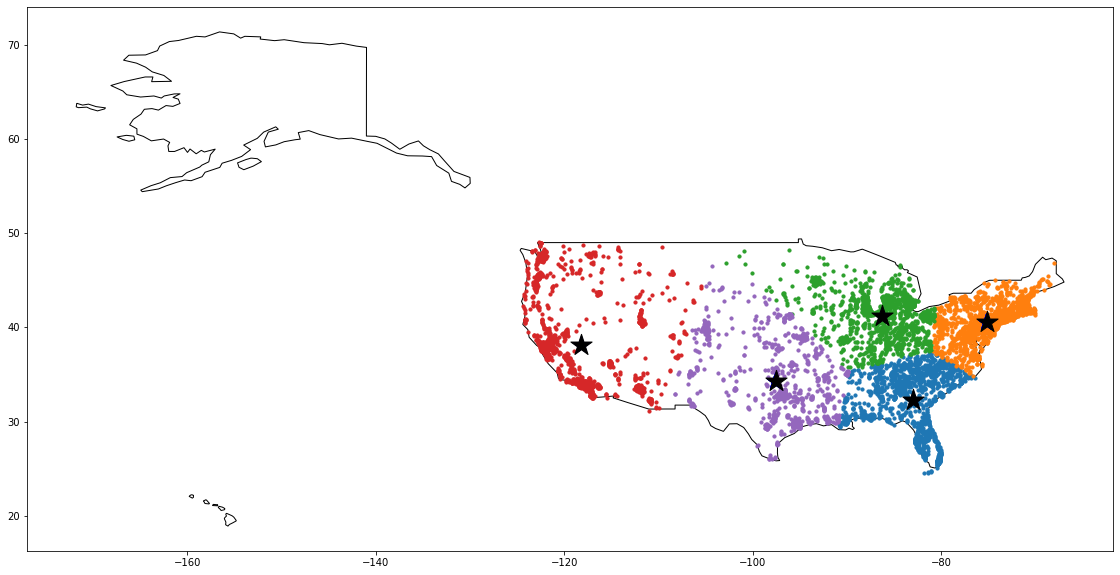

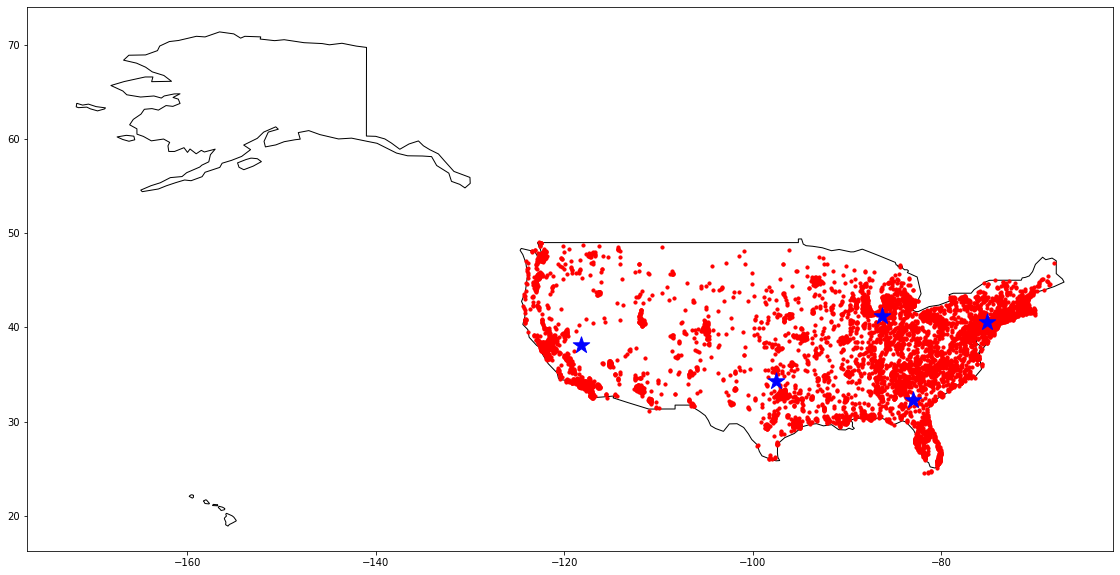

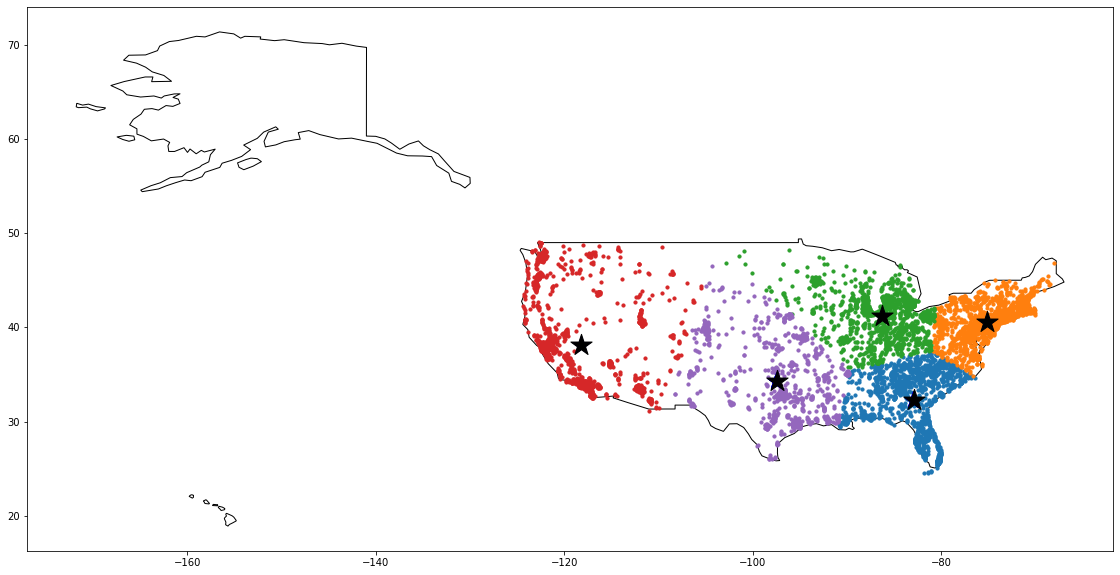

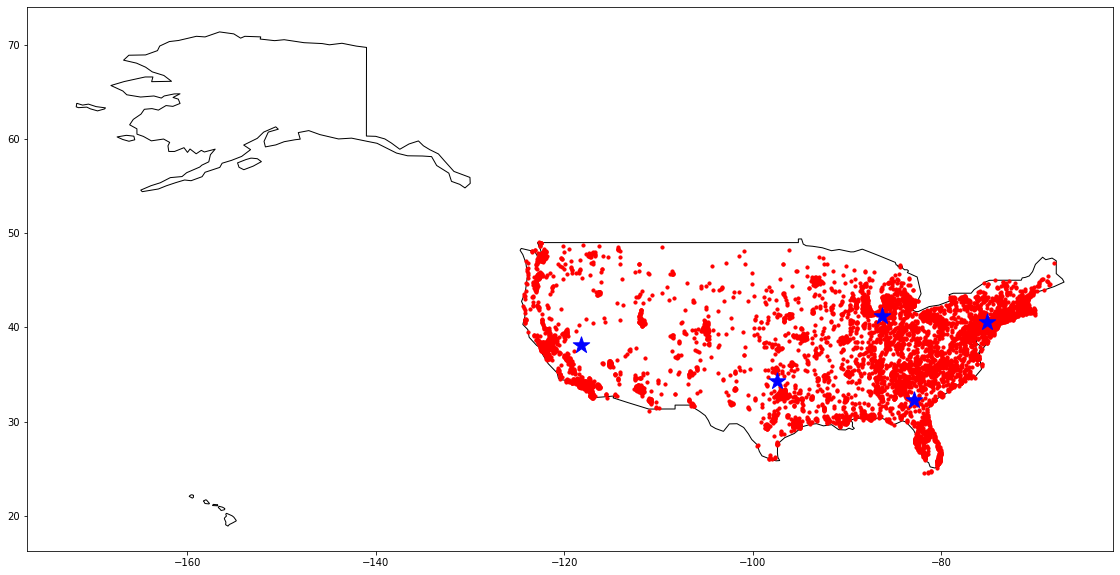

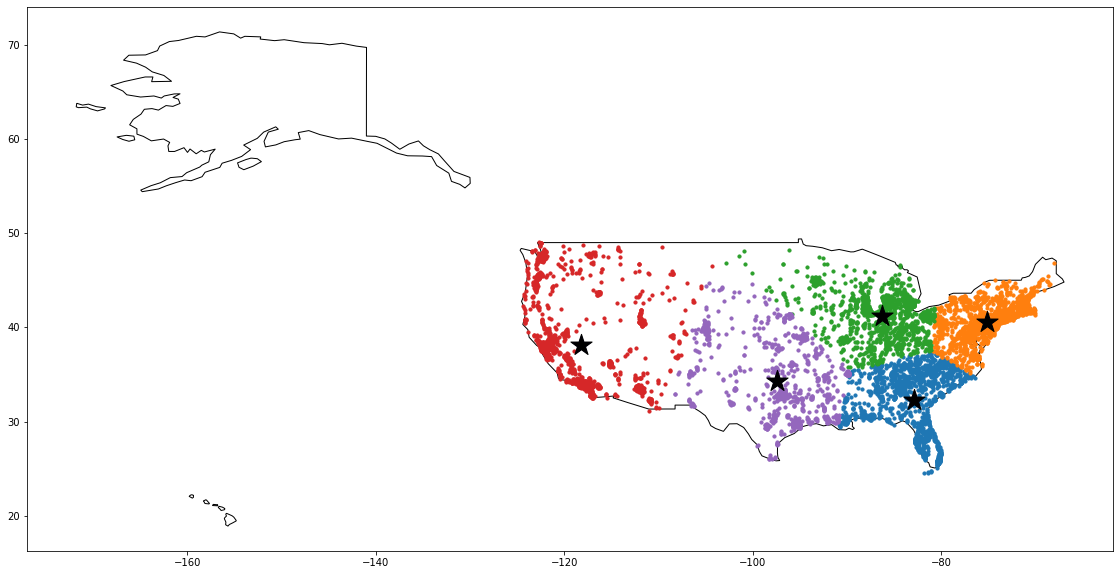

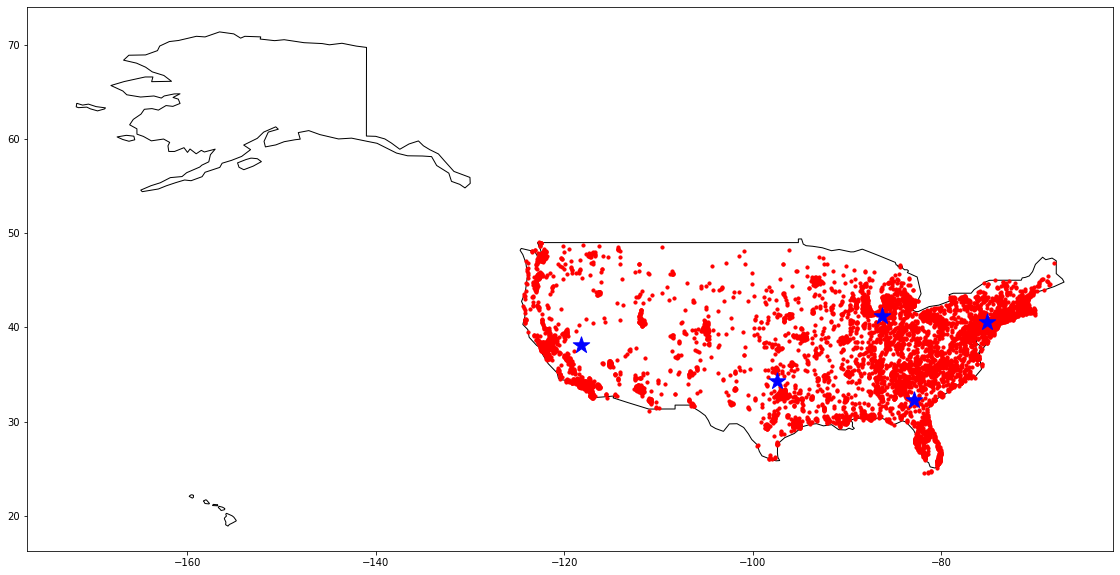

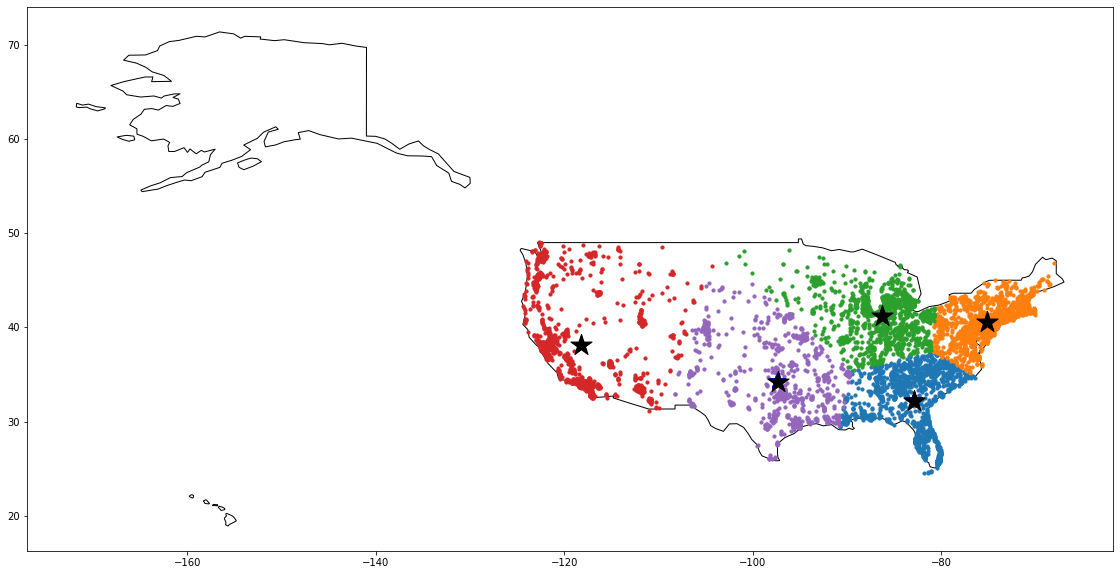

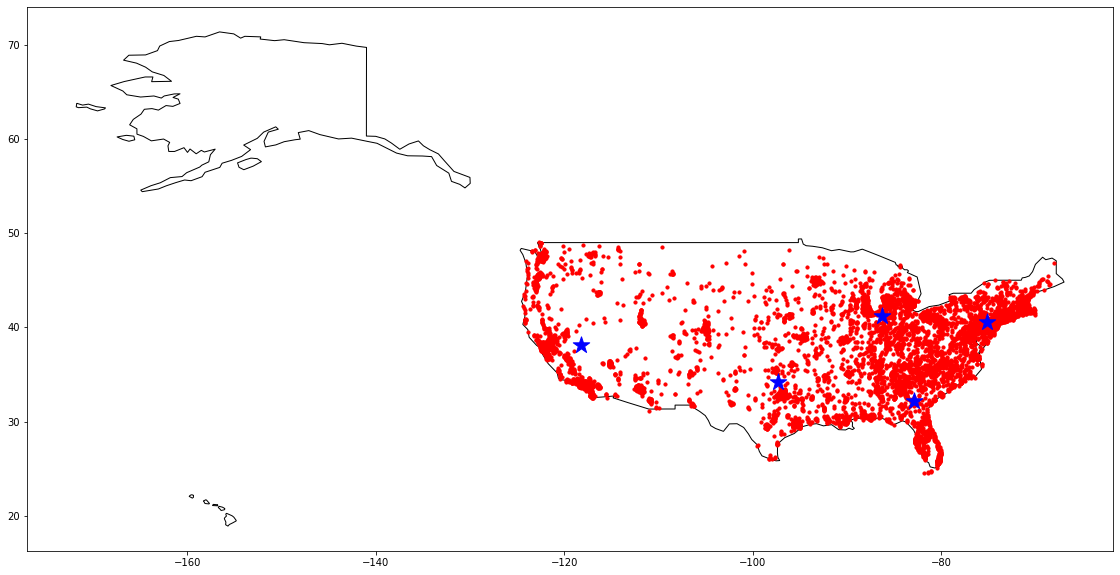

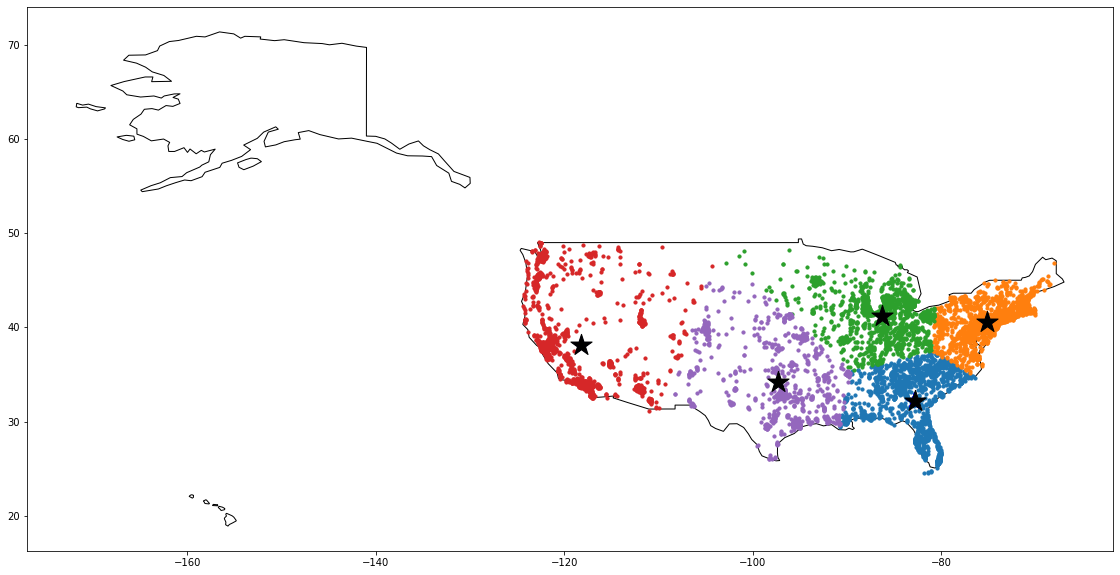

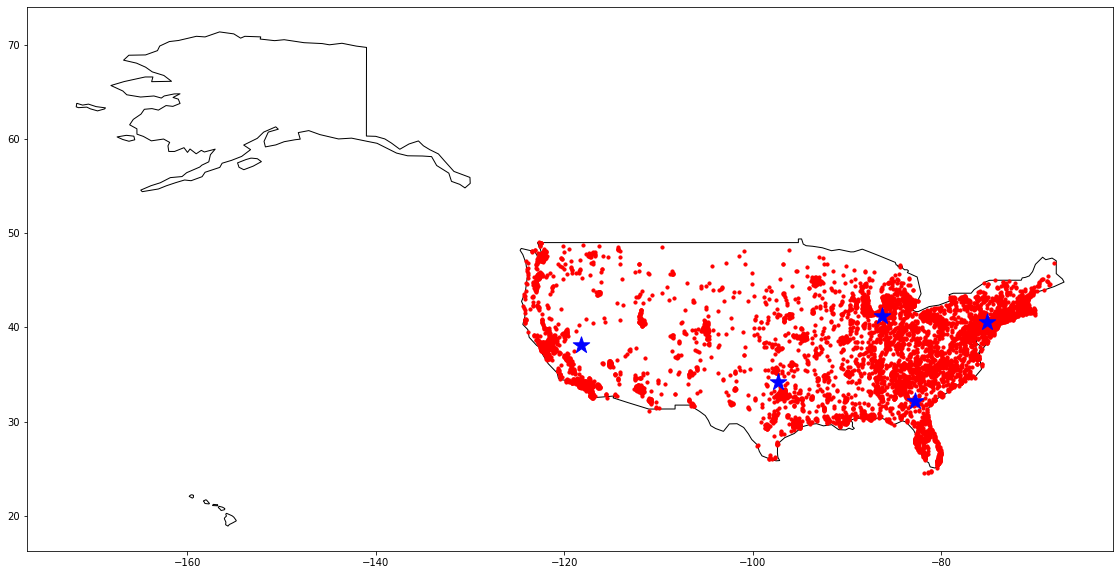

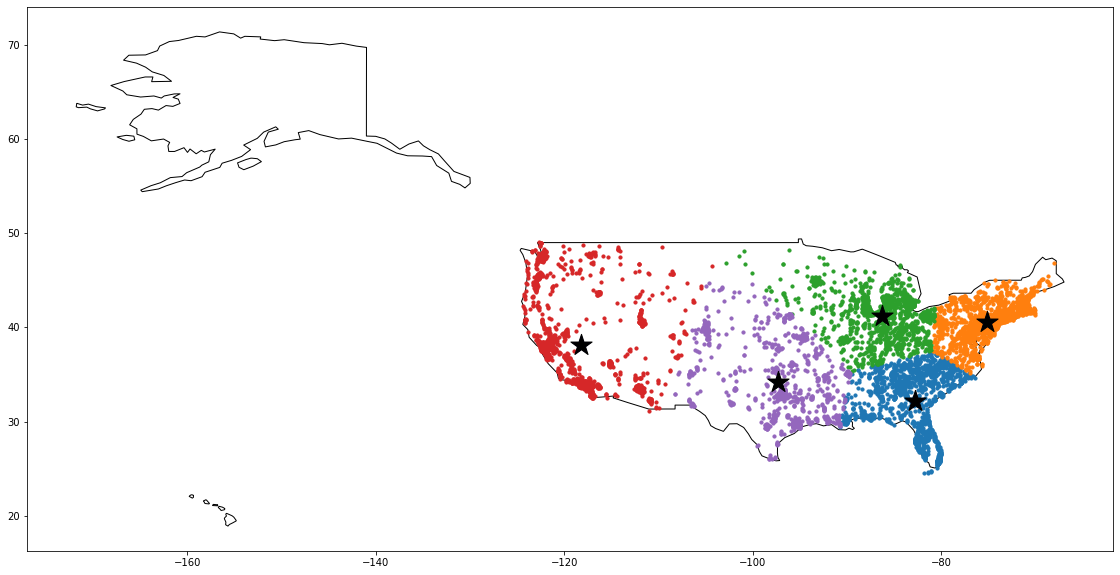

In [26]:
iternationDistanceFloat=99999999
while iternationDistanceFloat>5:
    
    #plot the points and initial centroids on the graph
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world[world.name == 'United States of America'].plot(color='white', edgecolor='black',figsize=(20, 10))
    geometry0=[Point(xy) for xy in zip(init['longitude'], init['latitude'])]
    gdf0=GeoDataFrame(init, geometry=geometry0)  
    geometry = [Point(xy) for xy in zip(data_pd['longitude'], data_pd['latitude'])]
    gdf = GeoDataFrame(data_pd, geometry=geometry)   
    gdf.plot(ax=ax, marker='o', color='red', markersize=10);
    gdf0.plot(ax=ax, marker='*', color='blue', markersize=300)
    
    #Formatting 
    centroid_df=pd.DataFrame(centroids)
    falttened_df=centroid_df.values.flatten()
    listToStr = ' '.join([str(elem) for elem in falttened_df])
    data_df_centroid=data_df.withColumn('centroid',F.lit(listToStr))
    
    #for each point find the closest centroid
    data_df_cc=data_df_centroid.withColumn("closest_centroid",cc(F.array('centroid','latitude', 'longitude')))
    
    #finding clusters
    data_df_list=data_df_cc.groupby(data_df_cc['closest_centroid'])\
    .agg(F.collect_list(data_df_cc['latitude']),F.collect_list(data_df_cc['longitude']))\
    .withColumnRenamed("collect_list(latitude)","lat_list",)\
    .withColumnRenamed("collect_list(longitude)","long_list")\
    .sort(data_df_cc['closest_centroid'])
 
    #Finding mean of every cluster & converting to pandas df
    with_mean=data_df_list.withColumn("mean",add_dd(F.array('lat_list', 'long_list')))   
    new_centroids=with_mean.withColumn("latitude",with_mean.mean[0]).withColumn("longitude",with_mean.mean[1])
    new_centroid_mean=new_centroids.select("latitude","longitude")
    new_centroids_pd=new_centroid_mean.toPandas()

    #plotting clusters with old mean(BLACK STAR) and new mean (BLUE STAR)
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax=world[world.name == 'United States of America'].plot(color='white', edgecolor='black',figsize=(20, 10))
    geometry_new_mean=[Point(xy) for xy in zip(new_centroids_pd['longitude'], new_centroids_pd['latitude'])]
    gdf_new_mean=GeoDataFrame(new_centroids_pd, geometry=geometry_new_mean) 
    for i in range(0,k):
        cluster_lat=data_df_list.select("lat_list").collect()[i]
        cluster_long=data_df_list.select("long_list").collect()[i]
        cluster_lat_df=pd.DataFrame(cluster_lat)
        cluster_long_df=pd.DataFrame(cluster_long)
        clusters=pd.concat([cluster_lat_df, cluster_long_df], axis=0)
        cluster_t=clusters.transpose()
        cluster_t.columns=["lat","long"]
        geometry_c=[Point(xy) for xy in zip(cluster_t['long'], cluster_t['lat'])]
        gdf_c=GeoDataFrame(cluster_t, geometry=geometry_c)  
        gdf_c.plot(ax=ax, marker='o', markersize=10)
        gdf0.plot(ax=ax, marker='*', color='blue', markersize=300)
    gdf_new_mean.plot(ax=ax, marker='*', color='black', markersize=500)
     
    #finding new centroid and mean
    init=new_centroids_pd
    new_centroids=new_centroid_mean.collect()  
    old_cent=sqlContext.createDataFrame(centroids)
    old_cent=old_cent.withColumnRenamed("latitude","old_latitude").withColumnRenamed("longitude","old_longitude").withColumn("id",F.row_number().over(ws))
    new_centroid_mean=new_centroid_mean.withColumnRenamed("latitude","new_latitude").withColumnRenamed("longitude","new_longitude").withColumn("id",F.row_number().over(ws))
    combined_old_new=old_cent.join(new_centroid_mean,on="id",how="outer") 
    distance=combined_old_new.withColumn("distance",distance_old_new(F.array("old_latitude","old_longitude","new_latitude","new_longitude"))).groupBy().agg(F.sum('distance'))
    distance.show()
    iterationDistance=distance.collect()[0]
    iternationDistanceFloat=(float(iterationDistance[0]))
    
    #Assigning new centroids for next iteration
    centroids=new_centroids